## Using API to fetch tweets

In [ ]:
import requests
import json
import csv
import tweepy 
from io import StringIO

# To set your environment variables in your terminal run the following line:
# export 'BEARER_TOKEN'='<your_bearer_token>'
bearer_token = "AAAAAAAAAAAAAAAAAAAAADMndQEAAAAAQp09J1DsJkLSjHgE6NOpAXKcXsE%3D3soxau8ySWP8m3GIxDLQcUO8j0OVrjiuBbZi9rTuQPM0KzxVJW"


def create_url():
    return "https://api.twitter.com/2/tweets/sample/stream"


def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2SampledStreamPython"
    return r


def connect_to_endpoint(url):
    
    ls = []
    time = 0
    response = requests.request("GET", url, auth=bearer_oauth, stream=True)
    print(response.status_code)
    for response_line in response.iter_lines():
        if response_line:
            json_response = json.loads(response_line)
            
            nested_json = json_response['data']
            ls.append(nested_json)
#             print(json.dumps(nested_json, indent=4, sort_keys=True))
            time += 1
            if time > 10:
                break
            
    if response.status_code != 200:
        raise Exception(
            "Request returned an error: {} {}".format(
                response.status_code, response.text
            )
        )
        
#     print(ls)
    final = json.dumps(ls, indent=2)
    df = pd.read_json(StringIO(final))
    print(df)
    df.to_csv('train.csv', encoding='utf-8', index=False)


def main():
    url = create_url()
    timeout = 0
    while True:
        connect_to_endpoint(url)
        timeout += 1
        
        if timeout == 10:
            break


if __name__ == "__main__":
    main()

## Preprocess tweets and analysis

In [1]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/Users/zacdeng/StudyRelated/JupyterNB/CE510-Social-Mining'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/Users/zacdeng/StudyRelated/JupyterNB/CE510-Social-Mining/CE510 Social Mining.ipynb
/Users/zacdeng/StudyRelated/JupyterNB/CE510-Social-Mining/.DS_Store
/Users/zacdeng/StudyRelated/JupyterNB/CE510-Social-Mining/submission.csv
/Users/zacdeng/StudyRelated/JupyterNB/CE510-Social-Mining/spacy-models/.DS_Store
/Users/zacdeng/StudyRelated/JupyterNB/CE510-Social-Mining/spacy-models/models/.DS_Store
/Users/zacdeng/StudyRelated/JupyterNB/CE510-Social-Mining/spacy-models/models/model_pos/tokenizer
/Users/zacdeng/StudyRelated/JupyterNB/CE510-Social-Mining/spacy-models/models/model_pos/meta.json
/Users/zacdeng/StudyRelated/JupyterNB/CE510-Social-Mining/spacy-models/models/model_pos/ner/moves
/Users/zacdeng/StudyRelated/JupyterNB/CE510-Social-Mining/spacy-models/models/model_pos/ner/cfg
/Users/zacdeng/StudyRelated/JupyterNB/CE510-Social-Mining/spacy-models/models/model_pos/ner/model
/Users/zacdeng/StudyRelated/JupyterNB/CE510-Social-Mining/spacy-models/models/model_pos/vocab/vectors
/Users/zacdeng/S

In [2]:
def random_colours(number_of_colors):
    '''
    Simple function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ['#E86DA4'] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

In [3]:
train = pd.read_csv('/Users/zacdeng/StudyRelated/JupyterNB/CE510-Social-Mining/train.csv')
test = pd.read_csv('/Users/zacdeng/StudyRelated/JupyterNB/CE510-Social-Mining/test.csv')
ss = pd.read_csv('/Users/zacdeng/StudyRelated/JupyterNB/CE510-Social-Mining/submission.csv')

In [4]:
print(train.shape)
print(test.shape)
print("---------------------------------------------------")
train.info()

(27481, 4)
(3534, 3)
---------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [5]:
train.dropna(inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


## EDA

In [6]:
train.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

In [7]:
train.describe()

textID                                  text selected_text  \
count        27480                                 27480         27480   
unique       27480                                 27480         22463   
top     cb774db0d1   I`d have responded, if I were going          good   
freq             1                                     1           199   

       sentiment  
count      27480  
unique         3  
top      neutral  
freq       11117

In [8]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

<AxesSubplot:xlabel='sentiment', ylabel='count'>

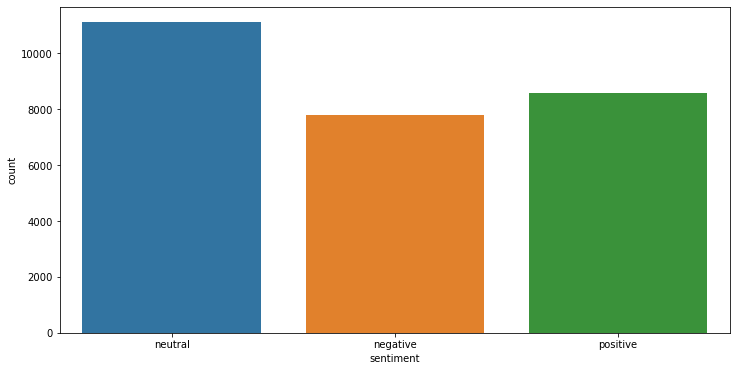

In [9]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=train)

In [10]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

In [11]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [12]:
results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [13]:
jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
train = train.merge(jaccard,how='outer')

In [14]:
train['Num_words_ST'] = train['selected_text'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text
train['Num_word_text'] = train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
train['difference_in_words'] = train['Num_word_text'] - train['Num_words_ST'] #Difference in Number of words text and Selected Text

In [15]:
train.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  jaccard_score  Num_words_ST  \
0  I`d have responded, if I were going   neutral       1.000000             7   
1                             Sooo SAD  negative       0.200000             2   
2                          bullying me  negative       0.166667             2   
3                       leave me alone  negative       0.600000             3   
4                        Sons of ****,  negative       0.214286             3   

   Num_word_text  difference_in_words  
0              7                    0  
1             10                    8  
2              5                    3  
3              5                    2  
4             14                   11

In [16]:
hist_data = [train['Num_words_ST'],train['Num_word_text']]

group_labels = ['Selected_Text', 'Text']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

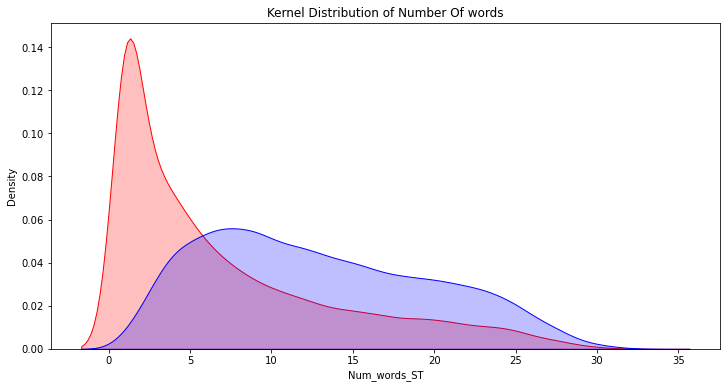

In [17]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train['Num_words_ST'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')
p1=sns.kdeplot(train['Num_word_text'], shade=True, color="b")

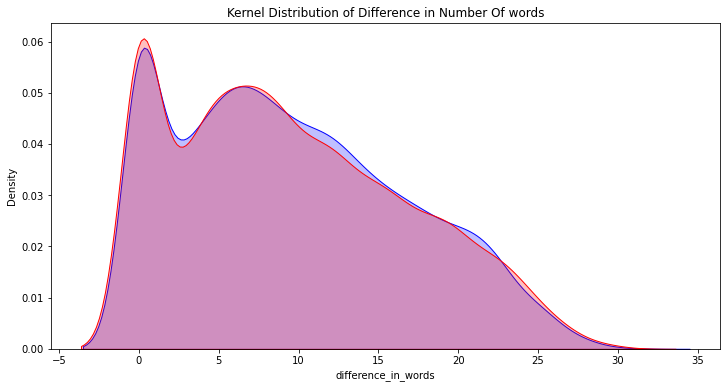

In [18]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['difference_in_words'], shade=True, color="b").set_title('Kernel Distribution of Difference in Number Of words')
p2=sns.kdeplot(train[train['sentiment']=='negative']['difference_in_words'], shade=True, color="r")

<AxesSubplot:xlabel='difference_in_words'>

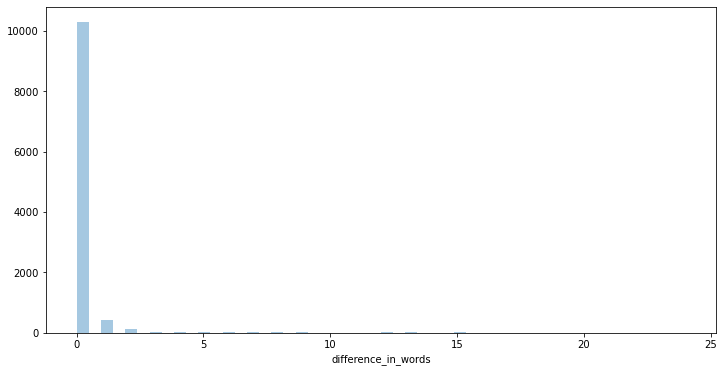

In [19]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['difference_in_words'],kde=False)

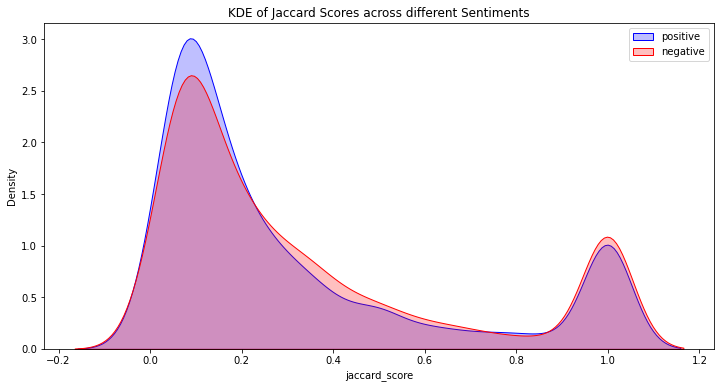

In [20]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['jaccard_score'], shade=True, color="b").set_title('KDE of Jaccard Scores across different Sentiments')
p2=sns.kdeplot(train[train['sentiment']=='negative']['jaccard_score'], shade=True, color="r")
plt.legend(labels=['positive','negative'])

<AxesSubplot:xlabel='jaccard_score'>

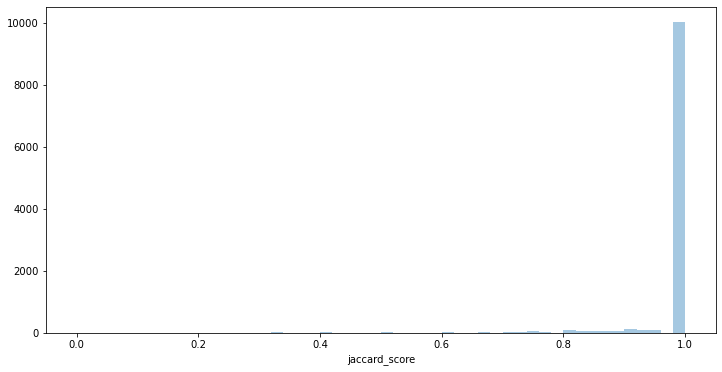

In [22]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['jaccard_score'],kde=False)

In [23]:
k = train[train['Num_word_text']<=2]
k.groupby('sentiment').mean()['jaccard_score']

sentiment
negative    0.788580
neutral     0.977805
positive    0.765700
Name: jaccard_score, dtype: float64

In [24]:
k[k['sentiment']=='positive']

textID                              text  \
68     fa2654e730                          Chilliin   
80     bbbc46889b   THANK YYYYYYYYYOOOOOOOOOOUUUUU!   
170    f3d95b57b1                      good morning   
278    89d5b3f0b5                            Thanks   
429    a78ef3e0d0                       Goodmorning   
...           ...                               ...   
26689  e80c242d6a                        Goodnight;   
26725  aad244f37d                             *hug*   
26842  a46571fe12                         congrats!   
26959  49a942e9b1                   Happy birthday.   
27292  47c474aaf1                       Good choice   

                         selected_text sentiment  jaccard_score  Num_words_ST  \
68                            Chilliin  positive            1.0             1   
80     THANK YYYYYYYYYOOOOOOOOOOUUUUU!  positive            1.0             2   
170                       good morning  positive            1.0             2   
278                             Thanks  positive            1.0             1   
429                        Goodmorning  positive            1.0             1   
...                                ...       ...            ...           ...   
26689                       Goodnight;  positive            1.0             1   
26725                            *hug*  positive            1.0             1   
26842                        congrats!  positive            1.0             1   
26959                  Happy birthday.  positive            1.0             2   
27292                             Good  positive            0.5             1   

       Num_word_text  difference_in_words  
68                 1                    0  
80                 2                    0  
170                2                    0  
278                1                    0  
429                1                    0  
...              ...                  ...  
26689              1                    0  
26725              1                    0  
26842              1                    0  
26959              2                    0  
27292              2                    1  

[207 rows x 8 columns]

In [25]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [26]:
train['text'] = train['text'].apply(lambda x:clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x:clean_text(x))

In [27]:
train.head()

textID                                               text  \
0  cb774db0d1                  id have responded if i were going   
1  549e992a42         sooo sad i will miss you here in san diego   
2  088c60f138                             my boss is bullying me   
3  9642c003ef                      what interview leave me alone   
4  358bd9e861   sons of  why couldnt they put them on the rel...   

                       selected_text sentiment  jaccard_score  Num_words_ST  \
0  id have responded if i were going   neutral       1.000000             7   
1                           sooo sad  negative       0.200000             2   
2                        bullying me  negative       0.166667             2   
3                     leave me alone  negative       0.600000             3   
4                           sons of   negative       0.214286             3   

   Num_word_text  difference_in_words  
0              7                    0  
1             10                    8  
2              5                    3  
3              5                    2  
4             14                   11

In [29]:
train['temp_list'] = train['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

In [30]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [58]:
nltk.download('stopwords')

def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
train['temp_list'] = train['temp_list'].apply(lambda x:remove_stopword(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zacdeng/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [59]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

In [60]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

In [61]:
train['temp_list1'] = train['text'].apply(lambda x:str(x).split()) #List of words in every row for text
train['temp_list1'] = train['temp_list1'].apply(lambda x:remove_stopword(x)) #Removing Stopwords

In [62]:
top = Counter([item for sublist in train['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

In [294]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words After Removing Stopwords', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [64]:
Positive_sent = train[train['sentiment']=='positive']
Negative_sent = train[train['sentiment']=='negative']
Neutral_sent = train[train['sentiment']=='neutral']

In [65]:
#MosT common positive words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

In [66]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [67]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

In [295]:
fig = px.bar(temp_negative, x="count", y="Common_words", title='Most Commmon Negative Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [68]:
fig = px.treemap(temp_negative, path=['Common_words'], values='count',title='Tree Of Most Common Negative Words')
fig.show()

In [207]:
#MosT common Neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Greys')

In [70]:
fig = px.bar(temp_neutral, x="count", y="Common_words", title='Most Commmon Neutral Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [71]:
fig = px.treemap(temp_neutral, path=['Common_words'], values='count',title='Tree Of Most Common Neutral Words')
fig.show()

In [72]:
raw_text = [word for word_list in train['temp_list1'] for word in word_list]

In [73]:
def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in train[train.sentiment != sentiment]['temp_list1']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in train[train.sentiment == sentiment]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

In [74]:
Unique_Positive= words_unique('positive', 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


In [75]:
fig = px.treemap(Unique_Positive, path=['words'], values='count',title='Tree Of Unique Positive Words')
fig.show()

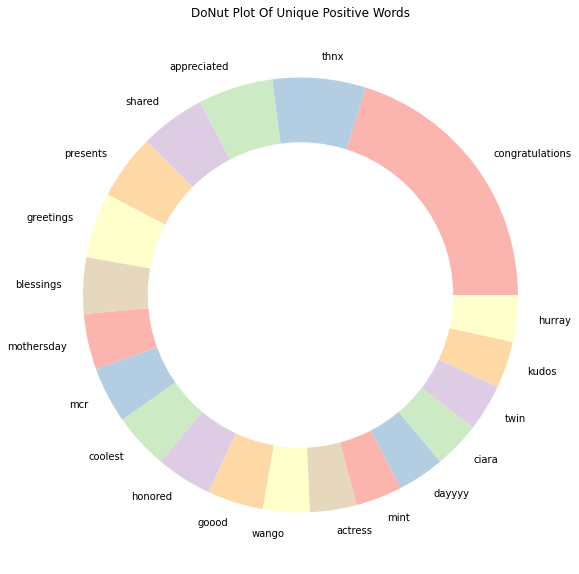

In [76]:
from palettable.colorbrewer.qualitative import Pastel1_7

plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Positive['count'], labels=Unique_Positive.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Positive Words')
plt.show()

In [77]:
Unique_Negative= words_unique('negative', 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


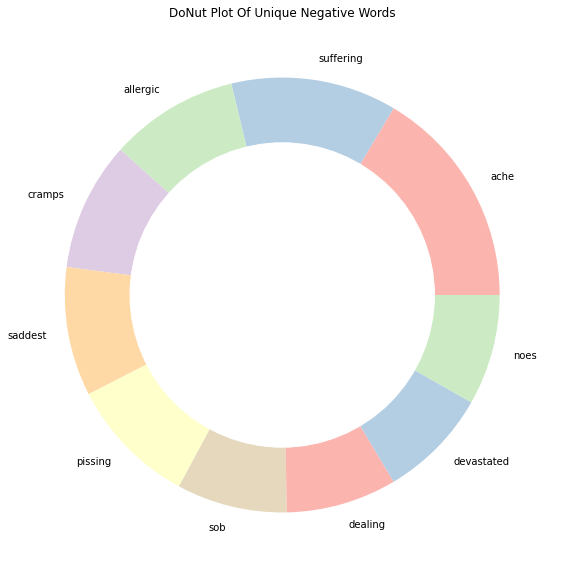

In [78]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.rcParams['text.color'] = 'black'
plt.pie(Unique_Negative['count'], labels=Unique_Negative.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Negative Words')
plt.show()

In [79]:
Unique_Neutral= words_unique('neutral', 10, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Oranges')

The top 10 unique words in Neutral Tweets are:


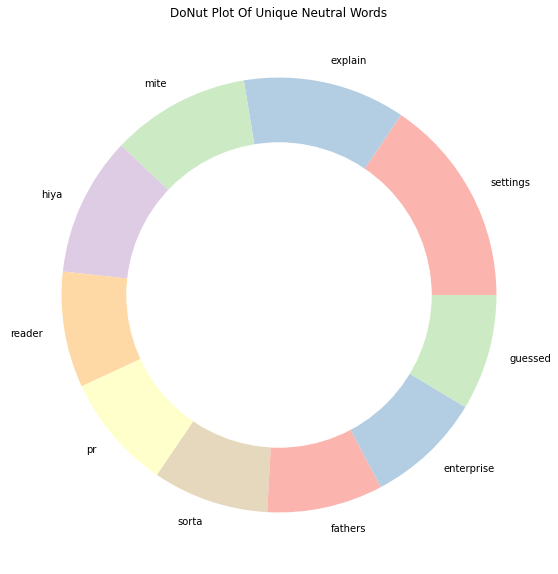

In [80]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Neutral['count'], labels=Unique_Neutral.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Neutral Words')
plt.show()

In [102]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=50, 
                    height=50,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
d = '/Users/zacdeng/StudyRelated/JupyterNB/CE510-Social-Mining/'

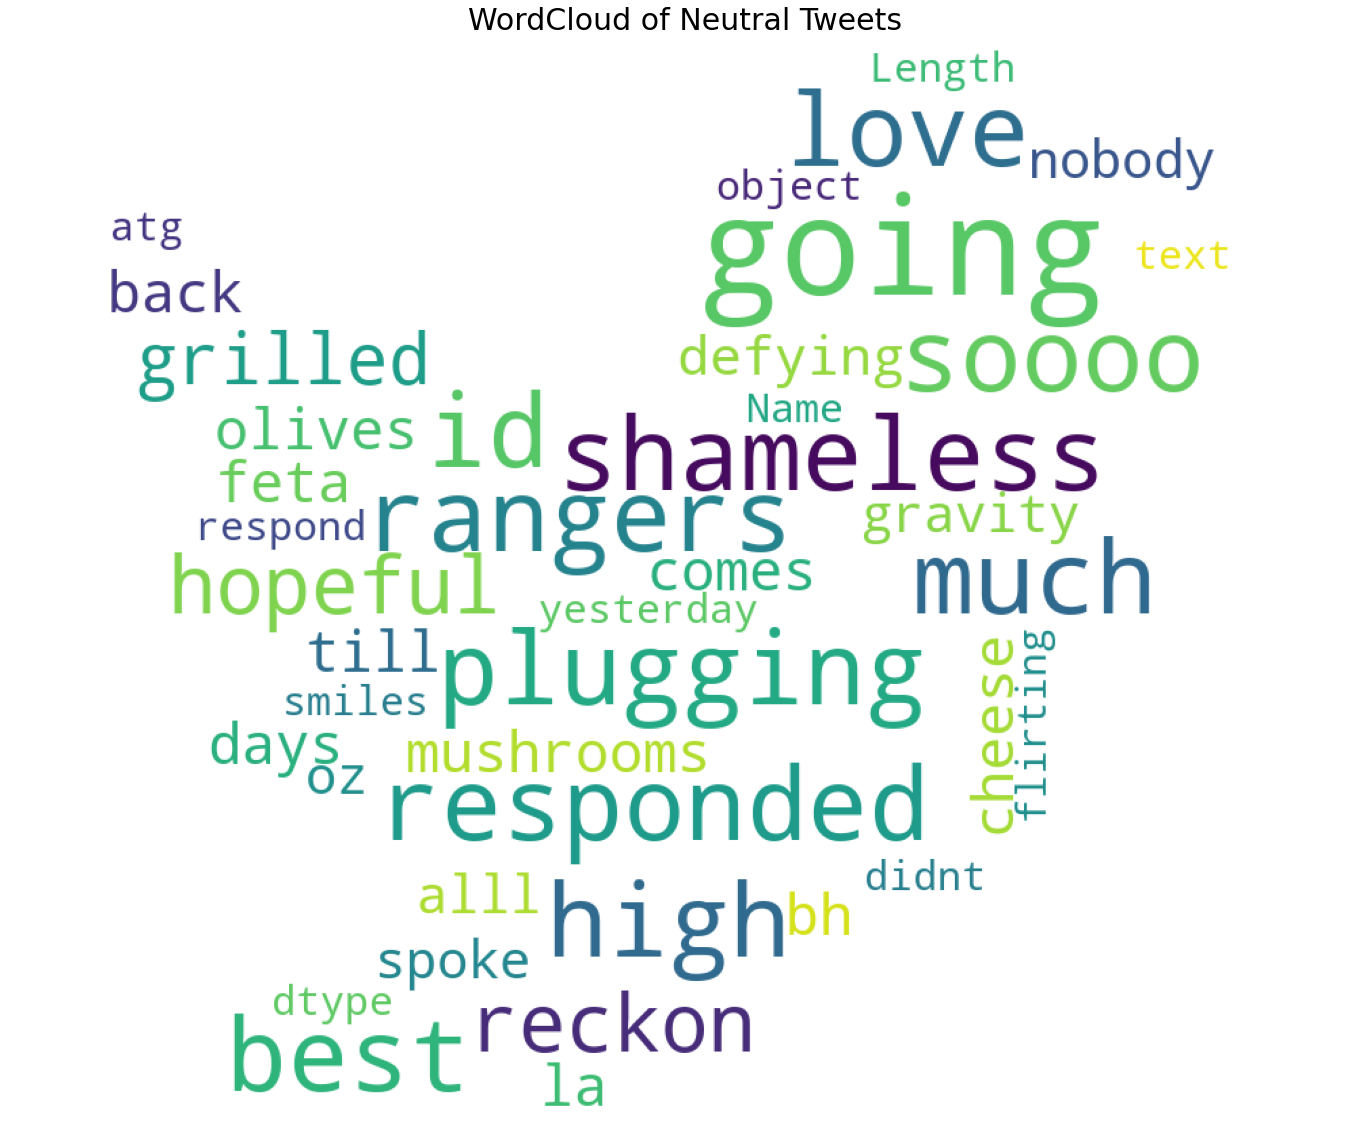

In [106]:
pos_mask = np.array(Image.open(d + 'twitter2.png'))
plot_wordcloud(Neutral_sent.text,mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets")

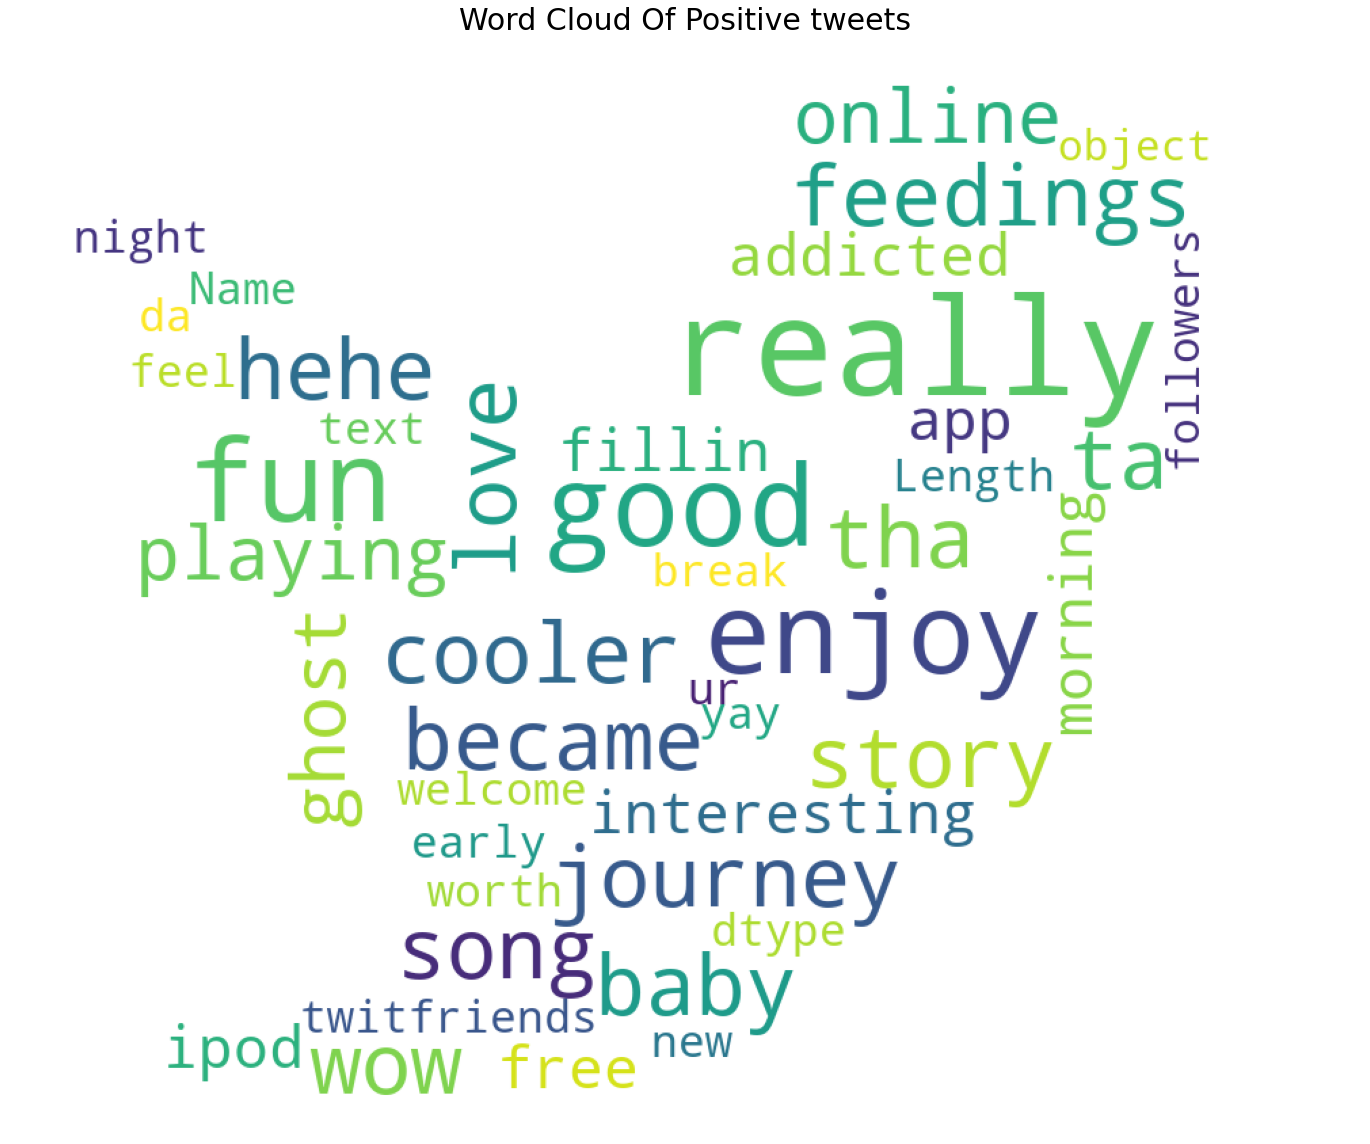

In [107]:
plot_wordcloud(Positive_sent.text,mask=pos_mask,title="Word Cloud Of Positive tweets",title_size=30)

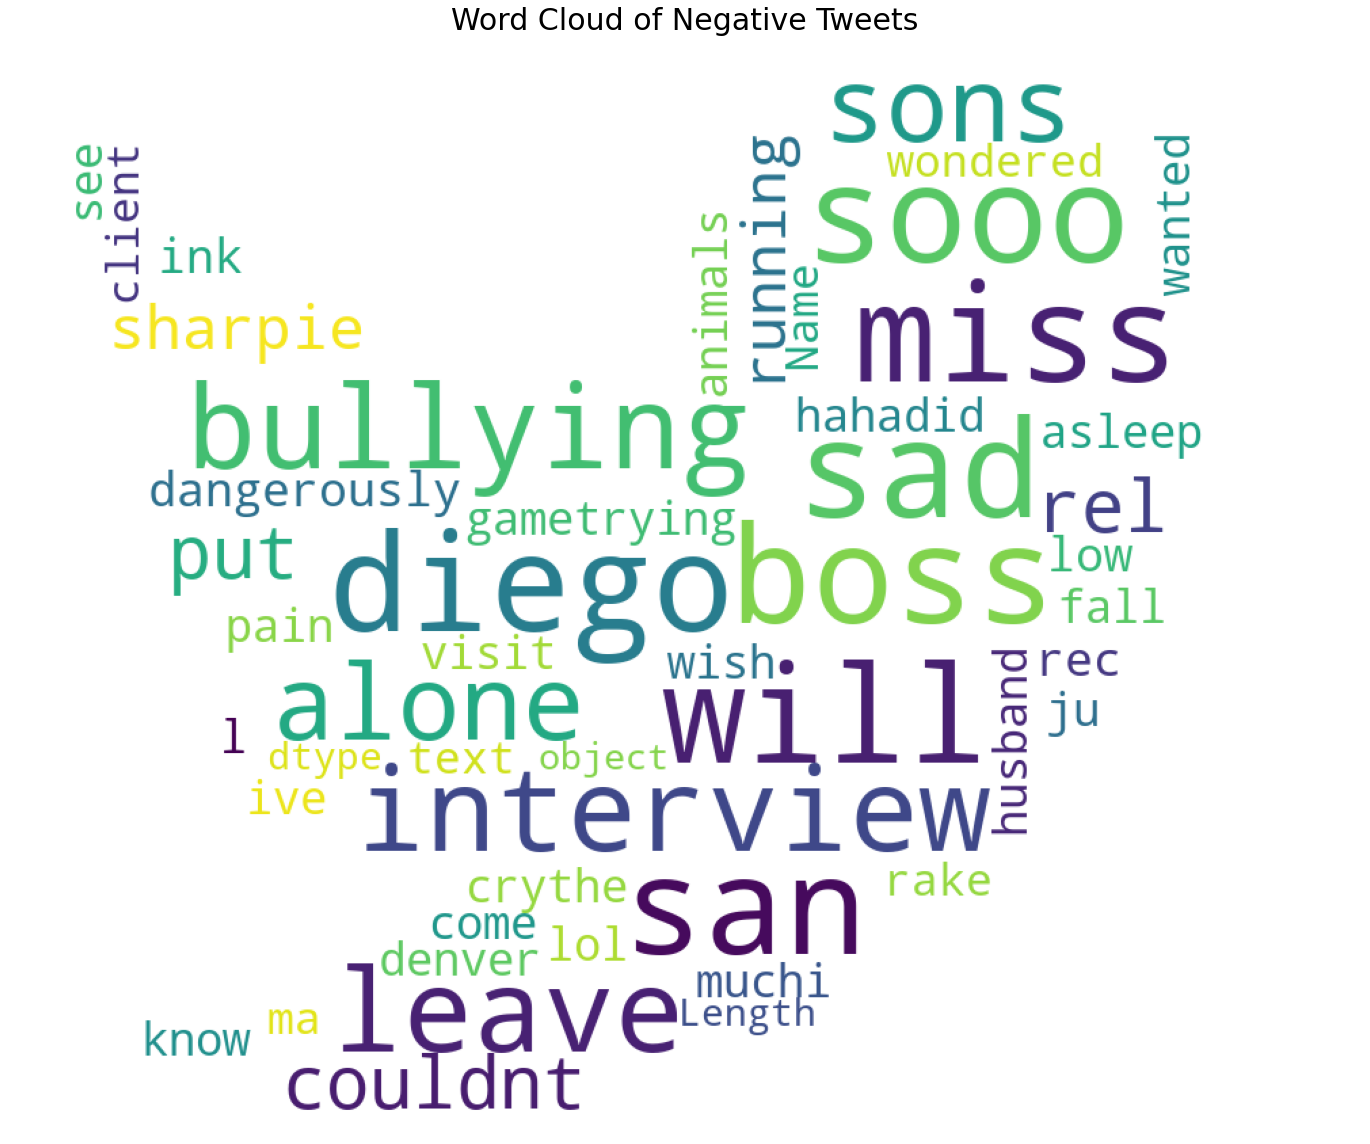

In [108]:
plot_wordcloud(Negative_sent.text,mask=pos_mask,title="Word Cloud of Negative Tweets",color='white',title_size=30)

### Modeling

In [109]:
df_train = pd.read_csv('/Users/zacdeng/StudyRelated/JupyterNB/CE510-Social-Mining/train.csv')
df_test = pd.read_csv('/Users/zacdeng/StudyRelated/JupyterNB/CE510-Social-Mining/test.csv')
df_submission = pd.read_csv('/Users/zacdeng/StudyRelated/JupyterNB/CE510-Social-Mining/sample_submission.csv')

In [110]:
df_train['Num_words_text'] = df_train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main Text in train set

In [111]:
df_train = df_train[df_train['Num_words_text']>=3]

In [112]:
def save_model(output_dir, nlp, new_model_name):
    ''' This Function Saves model to 
    given output directory'''
    
    output_dir = f'../working/{output_dir}'
    if output_dir is not None:        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        nlp.meta["name"] = new_model_name
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

In [193]:
# pass model = nlp if you want to train on top of existing model 
from spacy.training.example import Example

def train(train_data, output_dir, n_iter=20, model=None):
    """Load the model, set up the pipeline and train the entity recognizer."""
    ""
    if model is not None:
        nlp = spacy.load(output_dir)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")
    
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        nlp.add_pipe("ner", last=True)
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe('ner')
    
    # add labels

    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner = nlp.get_pipe('ner')
            
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        # sizes = compounding(1.0, 4.0, 1.001)
        # batch up the examples using spaCy's minibatch
        if model is None:
            nlp.begin_training()
        else:
            nlp.resume_training()


        for itn in tqdm(range(n_iter)):
            random.shuffle(train_data)
            batches = minibatch(train_data, size=compounding(4.0, 500.0, 1.001))    
            losses = {}
            for batch in batches:
                for text, annotations in batch:
                    # create Example
                    doc = nlp.make_doc(text)
                    example = Example.from_dict(doc, annotations)
                    # Update the model
                    nlp.update([example], losses=losses, drop=0.5)
                
            print("Losses", losses)
    save_model(output_dir, nlp, 'st_ner')

In [194]:
def get_model_out_path(sentiment):
    '''
    Returns Model output path
    '''
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = '/Users/zacdeng/StudyRelated/JupyterNB/CE510-Social-Mining/spacy-models/models/model_pos'
    elif sentiment == 'negative':
        model_out_path = '/Users/zacdeng/StudyRelated/JupyterNB/CE510-Social-Mining/spacy-models/models/model_neg'
    return model_out_path

In [197]:
def get_training_data(sentiment):
    '''
    Returns Trainong data in the format needed to train spacy NER
    '''
    train_data = []
    for index, row in df_train.iterrows():
        if row.sentiment == sentiment:
            selected_text = row.selected_text
            text = row.text
            start = text.find(selected_text)
            end = start + len(selected_text)
            train_data.append((text, {"entities": [[start, end, 'selected_text']]}))
    return train_data

In [198]:
sentiment = 'positive'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)
# For DEmo Purposes I have taken 3 iterations you can train the model as you want
train(train_data, model_path, n_iter=3, model=None)

Created blank 'en' model


 33%|███████████████████████████████▎                                                              | 1/3 [01:50<03:41, 110.70s/it]

Losses {'ner': 13337.226404424631}


 67%|██████████████████████████████████████████████████████████████▋                               | 2/3 [03:49<01:55, 115.64s/it]

Losses {'ner': 12574.716038624767}


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [05:52<00:00, 117.47s/it]

Losses {'ner': 12622.880516215731}
Saved model to ../working/models/model_pos


In [199]:
sentiment = 'negative'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=3, model=None)

Created blank 'en' model


 33%|███████████████████████████████▋                                                               | 1/3 [01:39<03:19, 99.90s/it]

Losses {'ner': 12766.597884518535}


 67%|███████████████████████████████████████████████████████████████▎                               | 2/3 [03:19<01:39, 99.68s/it]

Losses {'ner': 12233.587834821052}


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:52<00:00, 97.40s/it]

Losses {'ner': 11988.875100815341}
Saved model to ../working/models/model_neg


In [200]:
def predict_entities(text, model):
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    
    return selected_text

In [202]:
selected_texts = []
MODELS_BASE_PATH = '/Users/zacdeng/StudyRelated/JupyterNB/CE510-Social-Mining/spacy-models/models/'

if MODELS_BASE_PATH is not None:
    print("Loading Models  from ", MODELS_BASE_PATH)
    model_pos = spacy.load(MODELS_BASE_PATH + 'model_pos')
    model_neg = spacy.load(MODELS_BASE_PATH + 'model_neg')
        
    for index, row in df_test.iterrows():
        text = row.text
        output_str = ""
        if row.sentiment == 'neutral' or len(text.split()) <= 2:
            selected_texts.append(text)
        elif row.sentiment == 'positive':
            selected_texts.append(predict_entities(text, model_pos))
        else:
            selected_texts.append(predict_entities(text, model_neg))
        
df_test['selected_text'] = selected_texts

Loading Models  from  /Users/zacdeng/StudyRelated/JupyterNB/CE510-Social-Mining/spacy-models/models/


In [204]:
df_submission['selected_text'] = df_test['selected_text']
df_submission.to_csv("submission.csv", index=False)
display(df_submission.head(10))

textID                                      selected_text
0  f87dea47db  Last session of the day  http://twitpic.com/67ezh
1  96d74cb729                                               Good
2  eee518ae67  Recession hit Veronique Branquinho, she has to...
3  01082688c6                                        happy bday!
4  33987a8ee5             http://twitpic.com/4w75p - I like it!!
5  726e501993                                      that`s great!
6  261932614e            I THINK EVERYONE HATES ME ON HERE   lol
7  afa11da83f   soooooo wish i could, but im in school and my...
8  e64208b4ef   and within a short time of the last clue all ...
9  37bcad24ca   What did you get?  My day is alright.. haven`...

In [205]:
df_test['selected_text'].head()

0    Last session of the day  http://twitpic.com/67ezh
1                                                 Good
2    Recession hit Veronique Branquinho, she has to...
3                                          happy bday!
4               http://twitpic.com/4w75p - I like it!!
Name: selected_text, dtype: object

## Sentiment classification

In [279]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    print(accuracy_score(y_test, y_pred))

In [280]:
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

In [281]:
train = pd.read_csv('/Users/zacdeng/StudyRelated/JupyterNB/CE510-Social-Mining/train.csv')
train['selected_text'].replace('', np.nan, inplace=True)
train = train.dropna()

X_train, X_test, y_train, y_test = train_test_split(train['selected_text'], train['sentiment'],
                                                    test_size = 0.05, random_state = 0)

In [282]:
def lemmatize_tokenize(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text)]

In [283]:
vectorizer = TfidfVectorizer(tokenizer=lemmatize_tokenize, ngram_range=(1,2), max_features=30000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Vectoriser fitted.
No. of feature_words:  99495
Data Transformed.


In [284]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

    negative       0.82      0.40      0.53       367
     neutral       0.85      0.71      0.78       564
    positive       0.56      0.91      0.69       443

    accuracy                           0.69      1374
   macro avg       0.74      0.67      0.67      1374
weighted avg       0.75      0.69      0.68      1374

0.6928675400291121


In [285]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

    negative       0.84      0.80      0.82       367
     neutral       0.80      0.91      0.85       564
    positive       0.92      0.81      0.86       443

    accuracy                           0.85      1374
   macro avg       0.86      0.84      0.84      1374
weighted avg       0.85      0.85      0.85      1374

0.846433770014556


In [286]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

              precision    recall  f1-score   support

    negative       0.83      0.80      0.81       367
     neutral       0.79      0.91      0.85       564
    positive       0.93      0.78      0.85       443

    accuracy                           0.84      1374
   macro avg       0.85      0.83      0.84      1374
weighted avg       0.85      0.84      0.84      1374

0.8406113537117904


In [291]:
def predict(model, text, text_trans):
    # Predict the sentiment
    sentiment = model.predict(text_trans)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text, pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
#     df = df.replace([0,1], ["Negative","Positive"])
    return df

In [293]:
test = pd.read_csv('/Users/zacdeng/StudyRelated/JupyterNB/CE510-Social-Mining/submission.csv')
x_test = test['selected_text']

x_test_trans = vectoriser.transform(x_test)
print(f'Data Transformed.')

res = predict(SVCmodel, x_test, x_test_trans)
res.head(20)

Data Transformed.


text sentiment
0   Last session of the day  http://twitpic.com/67ezh   neutral
1                                                Good  positive
2   Recession hit Veronique Branquinho, she has to...  negative
3                                         happy bday!  positive
4              http://twitpic.com/4w75p - I like it!!   neutral
5                                       that`s great!  positive
6             I THINK EVERYONE HATES ME ON HERE   lol   neutral
7    soooooo wish i could, but im in school and my...   neutral
8    and within a short time of the last clue all ...   neutral
9    What did you get?  My day is alright.. haven`...   neutral
10                                             bummer  negative
11                          I checked.  We didn`t win  negative
12   .. and you`re on twitter! Did the tavern bore...   neutral
13  I`m in VA for the weekend, my youngest son tur...   neutral
14  Its coming out the socket  I feel like my phon...   neutral
15                                               hate  negative
16                                           Miss you  negative
17                                       Cramps . . .  negative
18                                               nice  positive
19  I`m going into a spiritual stagnentation, its ...   neutral